In [1]:
from langchain_openai import ChatOpenAI

model="gpt-3.5-turbo"
# model="gpt-4o"
# model="gpt-4-turbo-2024-04-09"

llm = ChatOpenAI(model=model)
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x000002601AD97850>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x000002601ADBCFA0>, openai_api_key=SecretStr('**********'), openai_proxy='')

## Tools


In [37]:
from langchain_core.tools import tool

# @tool
# def lookup_policy(query: str) -> str:
#     """Consult the company policies to check whether certain options are permitted.
#     Use this before making any flight changes performing other 'write' events."""
#     docs = retriever.query(query, k=2)
#     return "\n\n".join([doc["page_content"] for doc in docs])

@tool
def fetch_user_information(user_id: str):
    """
    Fetch user information
    This function retrieves user information from the database
    """
    print("-"*77)
    print("fetch_user_information 진입")
    print("user_id: ", user_id)
    # print("state\n", state)
    temp_info = """
    name: nadle
    사용자 이름: nadle
    구매 일자: 2024.06.18
    구매 상품:
    무지개 백설기 (12,000원) 3개
    개별 모듬팩 (5,000원) 2개
    떡케익 (25,000원) 1개
    총 구매 금액: 71,000원
    """
    return temp_info

@tool
def lookup_policy(message: str):
    """
    Consult the company policies regarding product exchanges and refunds.
    Use this function to check the company policies before proceeding with an exchange or refund.
    """
    temp_info = """
    교환/반품 안내

    제품수령 후 7일 이내 교환/반품 가능합니다.
    상품 하자 이외의 사이즈/색상 변경은 단순 변심에 의한 교환/반품이 불가능합니다.
    이미지를 보시는 기기의 성상차이나 색상, 사이즈 등 개인의 성호도에 따라 달리 느껴질 수 있습니다.
    
    교환/반품이 불가능한 경우
    제품의 라벨이나 신발박스가 훼손된 경우
    수제화 등 주문제작 상품의 경우
    오염물이 다르나 오염이 확실한 반품의 경우
    기간내에 상품을 보내주시고 교환/반품이 어려울정도로 훼손되어 보내주셨을 경우
    """
    return temp_info


@tool
def order():
    """
    Places a new order.
    This function processes a new order request and confirms
    """
    return "주문 완료"

@tool
def change_order():
    """
    Modifies an existing order.
    This function allows the user to change details of an existing
    """
    return "주문 변경 완료"

@tool
def cancel_order():
    """
    Cancels an existing order.
    This function processes the cancellation of an existing order
    """
    return "주문 취소 완료"

@tool
def view_order():
    """
    Views the details of a specific order.
    This function retrieves and returns the details of an order.
    """
    return "주문 조회 완료"

@tool
def view_change_order():
    """
    Views the details of a modified order.
    This function retrieves and returns the details of the changes made to an order.
    """
    return "주문 변경 조회 완료"

@tool
def view_cancel_order():
    """
    Views the details of a canceled order.
    This function retrieves and returns the details of a canceled order.
    """
    return "주문 취소 조회 완료"

In [22]:
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableLambda


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def extract_message_from_event(event: dict, max_length=1500):
    # print("event\n", event) # ts
    current_state = event["dialog_state"]
    if current_state:
        print("-"*77)
        print("Currently in: ", current_state)
    message = event.get("messages") 
    # print("message\n", message) # ts
    if message:
        if isinstance(message, list):
            message = message[-1]
        msg_repr = message.pretty_repr()
        if len(msg_repr) > max_length:
            msg_repr = msg_repr[:max_length] +  " ... (truncated)"
        return msg_repr

## Graph

### State

In [23]:
from typing import Annotated, Literal, Optional
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
            list[
                Literal[
                    "assistant",
                    "query",
                    "requset",
                ]
            ],
            update_dialog_stack,
        ]

### Assistant

In [16]:
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [17]:
from langchain_core.pydantic_v1 import BaseModel, Field

class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to use the tool to place a new order.",
            },
        }

### Create Assistant

In [18]:
from datetime import datetime
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# order inquiry assistant
order_inquiry_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling order queries. "
            "The primary assistant delegates work to you whenever the user needs help with their orders. "
            "Confirm the order details with the customer and inform them of any additional information. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            "\n\nCurrent user order information:\n<Orders>\n{user_info}\n</Orders>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
).partial(time=datetime.now())

inquiry_tools = [view_order, view_change_order, view_cancel_order]
order_inquiry_runnable = order_inquiry_prompt | llm.bind_tools(   
    inquiry_tools + [CompleteOrEscalate]
)
order_inquiry_runnable

# order request assistant
order_request_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling order queries. "
            "The primary assistant delegates work to you whenever the user needs help with their orders. "
            "Perform the order placement, modification, or cancellation as requested by the customer and inform them of any additional information or fees."
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            "\n\nCurrent user order information:\n<Orders>\n{user_info}\n</Orders>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
).partial(time=datetime.now())

request_tools = [order, change_order, cancel_order]
order_request_runnable = order_request_prompt | llm.bind_tools(   
    request_tools + [CompleteOrEscalate]
)
order_request_runnable

# Primary Assistant
class ToOrderInquiryAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle order queries."""

    order_id: int = Field(description="The ID of the order to query.")
    request: str = Field(description="Any necessary follow-up questions the querying assistant should clarify before proceeding.")

class ToOrderRequestAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle order placements, modifications, or cancellations."""

    order_id: int = Field(description="The ID of the order to update.")
    action: str = Field(description="The action to perform: 'order', 'change_order', 'cancel_order'.")
    request: str = Field(description="Any additional information or requests from the user regarding the order.")


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant "
            "Your primary role is to search for company policies to answer customer queries. "
            "If a customer requests order-related inquiries (such as checking past orders, viewing order changes, or viewing order cancellations)"
            "or order-related requests (such as placing an order, changing an order, or canceling an order), delegate the task to the appropriate specialized assistant."
            "Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        # ("placeholder", "{messages}"),
        MessagesPlaceholder(variable_name="messages")
    ]
).partial(time=datetime.now())

primary_assistant_tools = [
    lookup_policy,
]
primary_assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToOrderInquiryAssistant,
        ToOrderRequestAssistant,
        ]
    )

## Utilities


In [19]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and action like order lookup and order request is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

### Define Graph

In [34]:
from typing import Literal

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    print("-"*77)
    print("user_info 진입")
    print("state\n", state)
    return {"user_info": fetch_user_information.invoke({"state": "dummy", "user_id": "nadle"})}


builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")

# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }

builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")


# order inquiry assistant
builder.add_node(
    "enter_order_inquiry",
    create_entry_node("Order Inqury Assistant", "order_inquiry"),
)
builder.add_node("order_inquiry", Assistant(order_inquiry_runnable))
builder.add_edge("enter_order_inquiry", "order_inquiry")
builder.add_node(
    "inquiry_tools",
    create_tool_node_with_fallback(inquiry_tools),
)
builder.add_edge("inquiry_tools", "order_inquiry")

def route_order_inquiry(
        state: State,
) -> Literal[
    "inquiry_tools",
    "leave_skill",
    "__end__"
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    return "inquiry_tools"

builder.add_conditional_edges("order_inquiry", route_order_inquiry)


# order request assistant
builder.add_node(
    "enter_order_request",
    create_entry_node("Order Request Assistant", "order_request"),
)
builder.add_node("order_request", Assistant(order_request_runnable))
builder.add_edge("enter_order_request", "order_request")
builder.add_node(
    "request_tools",
    create_tool_node_with_fallback(request_tools),
)
builder.add_edge("request_tools", "order_request")

def route_order_inquiry(
        state: State,
) -> Literal[
    "request_tools",
    "leave_skill",
    "__end__"
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    return "request_tools"

builder.add_conditional_edges("order_request", route_order_inquiry)


# Primary assistant
builder.add_node("primary_assistant", Assistant(primary_assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)
builder.add_edge("primary_assistant_tools", "primary_assistant")

def route_primary_assistant(
        state: State,
) -> Literal[
    "primary_assistant_tools",
    "enter_order_inquiry",
    "enter_order_request",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToOrderInquiryAssistant.__name__:
            return "enter_order_inquiry"
        elif tool_calls[0]["name"] == ToOrderRequestAssistant.__name__:
            return "enter_order_request"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")

builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_order_inquiry": "enter_order_inquiry",
        "enter_order_request": "enter_order_request",
        "primary_assistant_tools": "primary_assistant_tools",
        END: END,
    },
)


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "order_inquiry",
    "order_request",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]

builder.add_conditional_edges("fetch_user_info", route_to_workflow)
# builder.add_conditional_edges(
#     "fetch_user_info", 
#     route_to_workflow,
#     # END 경우는 고려 필요 없겠지? dialog_state[-1] 있단 말이니. enter_order_inquiry가 아닌 order_inquiry 맞나?
#     {
#         "primary_assistant": "primary_assistant",
#         "order_inquiry": "order_inquiry",
#         "order_request": "order_request",
#      },
#     )

memory = SqliteSaver.from_conn_string(":memory:")
orderbot_graph = builder.compile(
    checkpointer=memory,
    interrupt_before=[
        "request_tools",
    ],
)

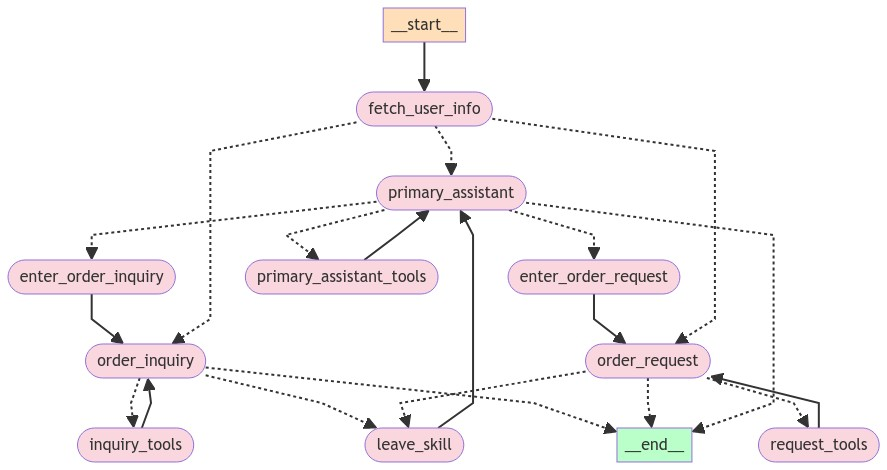

In [12]:
from IPython.display import Image, display

try:
    display(Image(orderbot_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Conversation

In [39]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    events = orderbot_graph.stream(
        {"messages": ("user", question),
         "user_info": "nadle"}, config, stream_mode="values"
    )
    for event in events:
        response = extract_message_from_event(event)
        print(response)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Cㄴontinue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

================================ Human Message =================================

교환 정보 알고 싶어
-----------------------------------------------------------------------------
user_info 진입
state
 {'messages': [HumanMessage(content='교환 정보 알고 싶어', id='9b05bca2-3edd-4beb-a61a-0e7483517e8f')], 'user_info': 'nadle', 'dialog_state': []}
-----------------------------------------------------------------------------
fetch_user_information 진입
user_id:  nadle
================================ Human Message =================================

교환 정보 알고 싶어
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_BwqHJGXfW2rFOLSQo7wIKNlJ)
 Call ID: call_BwqHJGXfW2rFOLSQo7wIKNlJ
  Args:
    message: exchange
================================= Tool Message =================================
Name: lookup_policy


    교환/반품 안내

    제품수령 후 7일 이내 교환/반품 가능합니다.
    상품 하자 이외의 사이즈/색상 변경은 단순 변심에 의한 교환/반품이 불가능합니다.
    이미지를 보시는 기기의 성상차이나 색상, 사이즈 등 개인의 성호도에 따라 달리 느

그래프 호출 메서드 stream() -> invoke()로 변경

In [46]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "1089",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

while True:
    question = input("메시지를 입력하세요~")
    if question == "stop":
        break
    response = orderbot_graph.invoke({"messages": ("user", question)}, config)
    print("response\n", response["messages"][-1].pretty_repr())
    # events = orderbot_graph.stream(
    #     {"messages": ("user", question),
    #      "user_info": "nadle"}, config, stream_mode="values"
    # )
    # for event in events:
    #     response = extract_message_from_event(event)
    #     print(response)
    snapshot = orderbot_graph.get_state(config)
    print("snapshot\n", snapshot)
    while snapshot.next:
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = orderbot_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = orderbot_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=response["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Cㄴontinue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = orderbot_graph.get_state(config)

-----------------------------------------------------------------------------
user_info 진입
state
 {'messages': [HumanMessage(content='교환 정보 알고 싶어요', id='a2399161-643c-4742-ac9b-c9becdb24ffc')], 'user_info': None, 'dialog_state': []}
-----------------------------------------------------------------------------
fetch_user_information 진입
user_id:  nadle
response
 ================================== Ai Message ==================================

제품 수령 후 7일 이내에 교환 및 반품이 가능하며, 상품 하자를 제외한 사이즈나 색상 변경에는 단순 변심에 의한 교환 및 반품이 불가능합니다. 제품의 라벨이나 신발박스가 훼손된 경우, 수제화 등 주문 제작 상품, 오염물이 다르거나 확실한 반품의 경우, 그리고 제품이 훼손되어 교환 및 반품이 어려울 정도로 손상된 경우에는 교환 및 반품이 불가능합니다.
snapshot
 StateSnapshot(values={'messages': [HumanMessage(content='교환 정보 알고 싶어요', id='a2399161-643c-4742-ac9b-c9becdb24ffc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TkBPau2mHMWE8Hf86ff7crs3', 'function': {'arguments': '{"message":"exchange"}', 'name': 'lookup_policy'}, 'type': 'function'}]}, response_metadata={'token_usage': 